In [2]:
pip install python-bcb

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: python-bcb in c:\users\ryan\appdata\local\programs\python\python313\lib\site-packages (0.3.3)




[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Realizar uma análise gráfica das séries fornecidas. 

2. Realizar testes de raiz unitária em todas as séries. 

3. Estimar via MQO a equação Bovespa = Inflação + Juros + IBC-br + câmbio 

4. Estimar a mesma equação via GMM

5. Estimar um VAR e gerar os gráficos de impulso resposta e a tabela de decomposição da variância

In [3]:
import pandas as pd
from bcb import sgs

print("Iniciando a extração de dados do Banco Central do Brasil...")

# 1. DEFINIÇÃO DOS CÓDIGOS DAS SÉRIES
# Um dicionário para facilitar a identificação de cada série.
# Chave = Nome da coluna no nosso dataset final
# Valor = Código da série no SGS do BCB
codigos_bcb = {
    'IPCA_12M': 13522,      # IPCA - Acumulado 12 meses
    'SELIC_ANUAL': 4189,     # Taxa de juros - Selic definida pelo Copom (anual)
    'IBOVESPA': 7845,        # Índice Bovespa - Média do período (mensal)
    'IBC-Br': 24369,         # IBC-Br - Índice de atividade econômica do BCB com ajuste sazonal
    'CAMBIO_DOLAR': 3695     # Taxa de câmbio - Dólar americano (venda) - Fim de período (mensal)
}

# 2. BUSCA DAS SÉRIES NO SGS
# Usaremos a função sgs.get() para buscar todas as séries de uma vez.
# Definimos uma data de início para a coleta dos dados.
try:
    data_inicio = '2005-01-01'

    # A biblioteca busca os dados e já os retorna em um DataFrame do pandas
    df_series = sgs.get(codigos_bcb, start=data_inicio)

    print("\nDados extraídos com sucesso. Visualizando as primeiras linhas:")
    print(df_series.head())

    # 3. TRATAMENTO DOS DADOS
    # Vamos verificar se há dados faltantes.
    print("\nVerificando valores nulos antes do tratamento:")
    print(df_series.isnull().sum())

    # O método 'ffill' (forward fill) preenche valores nulos com o último valor válido.
    # Isso é útil para séries como a Selic, que muda em reuniões do Copom e não diariamente.
    df_series.fillna(method='ffill', inplace=True)

    # Removemos qualquer linha que ainda possa ter algum valor nulo (geralmente no início do período)
    df_series.dropna(inplace=True)

    print("\nVerificando valores nulos após o tratamento:")
    print(df_series.isnull().sum())

    print("\nVisualizando as últimas linhas do dataset final:")
    print(df_series.tail())

    # 4. EXPORTAÇÃO PARA EXCEL
    # Definimos o nome do arquivo de saída
    nome_arquivo_excel = 'series_temporais_bcb.xlsx'

    # Usamos a função to_excel() do pandas para salvar o DataFrame
    df_series.to_excel(nome_arquivo_excel, sheet_name='Dados BCB')

    print(f"\nO dataset foi salvo com sucesso no arquivo: '{nome_arquivo_excel}'")

except Exception as e:
    print(f"\nOcorreu um erro durante a execução: {e}")

Iniciando a extração de dados do Banco Central do Brasil...

Dados extraídos com sucesso. Visualizando as primeiras linhas:
            IPCA_12M  SELIC_ANUAL  IBOVESPA  IBC-Br  CAMBIO_DOLAR
Date                                                             
2005-01-01      7.41        17.93   24350.0     NaN        2.6240
2005-02-01      7.39        18.47   28139.0     NaN        2.5942
2005-03-01      7.54        18.97   26610.0     NaN        2.6654
2005-04-01      8.07        19.32   24843.0     NaN        2.5305
2005-05-01      8.05        19.61   25207.0     NaN        2.4030

Verificando valores nulos antes do tratamento:
IPCA_12M         2
SELIC_ANUAL      0
IBOVESPA        76
IBC-Br          88
CAMBIO_DOLAR     2
dtype: int64

Verificando valores nulos após o tratamento:
IPCA_12M        0
SELIC_ANUAL     0
IBOVESPA        0
IBC-Br          0
CAMBIO_DOLAR    0
dtype: int64

Visualizando as últimas linhas do dataset final:
            IPCA_12M  SELIC_ANUAL  IBOVESPA  IBC-Br  CAMBIO

C:\Users\Ryan\AppData\Local\Temp\ipykernel_11440\3691204590.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_series.fillna(method='ffill', inplace=True)



O dataset foi salvo com sucesso no arquivo: 'series_temporais_bcb.xlsx'


Primeiras linhas do DataFrame:
            IPCA  SELIC  IBOVESPA  IBCBR  CAMBIO
Date                                            
2012-03-01  5.24   9.82     64510    8.0  1.8215
2012-04-01  5.10   9.35     61820    7.8  1.8912
2012-05-01  4.99   8.87     54490    7.7  2.0217
2012-06-01  4.92   8.39     54354    7.6  2.0207
2012-07-01  5.20   8.07     56097    7.5  2.0494

Informações sobre o DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166 entries, 2012-03-01 to 2025-12-01
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPCA      166 non-null    float64
 1   SELIC     166 non-null    float64
 2   IBOVESPA  166 non-null    int64  
 3   IBCBR     166 non-null    float64
 4   CAMBIO    166 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.8 KB


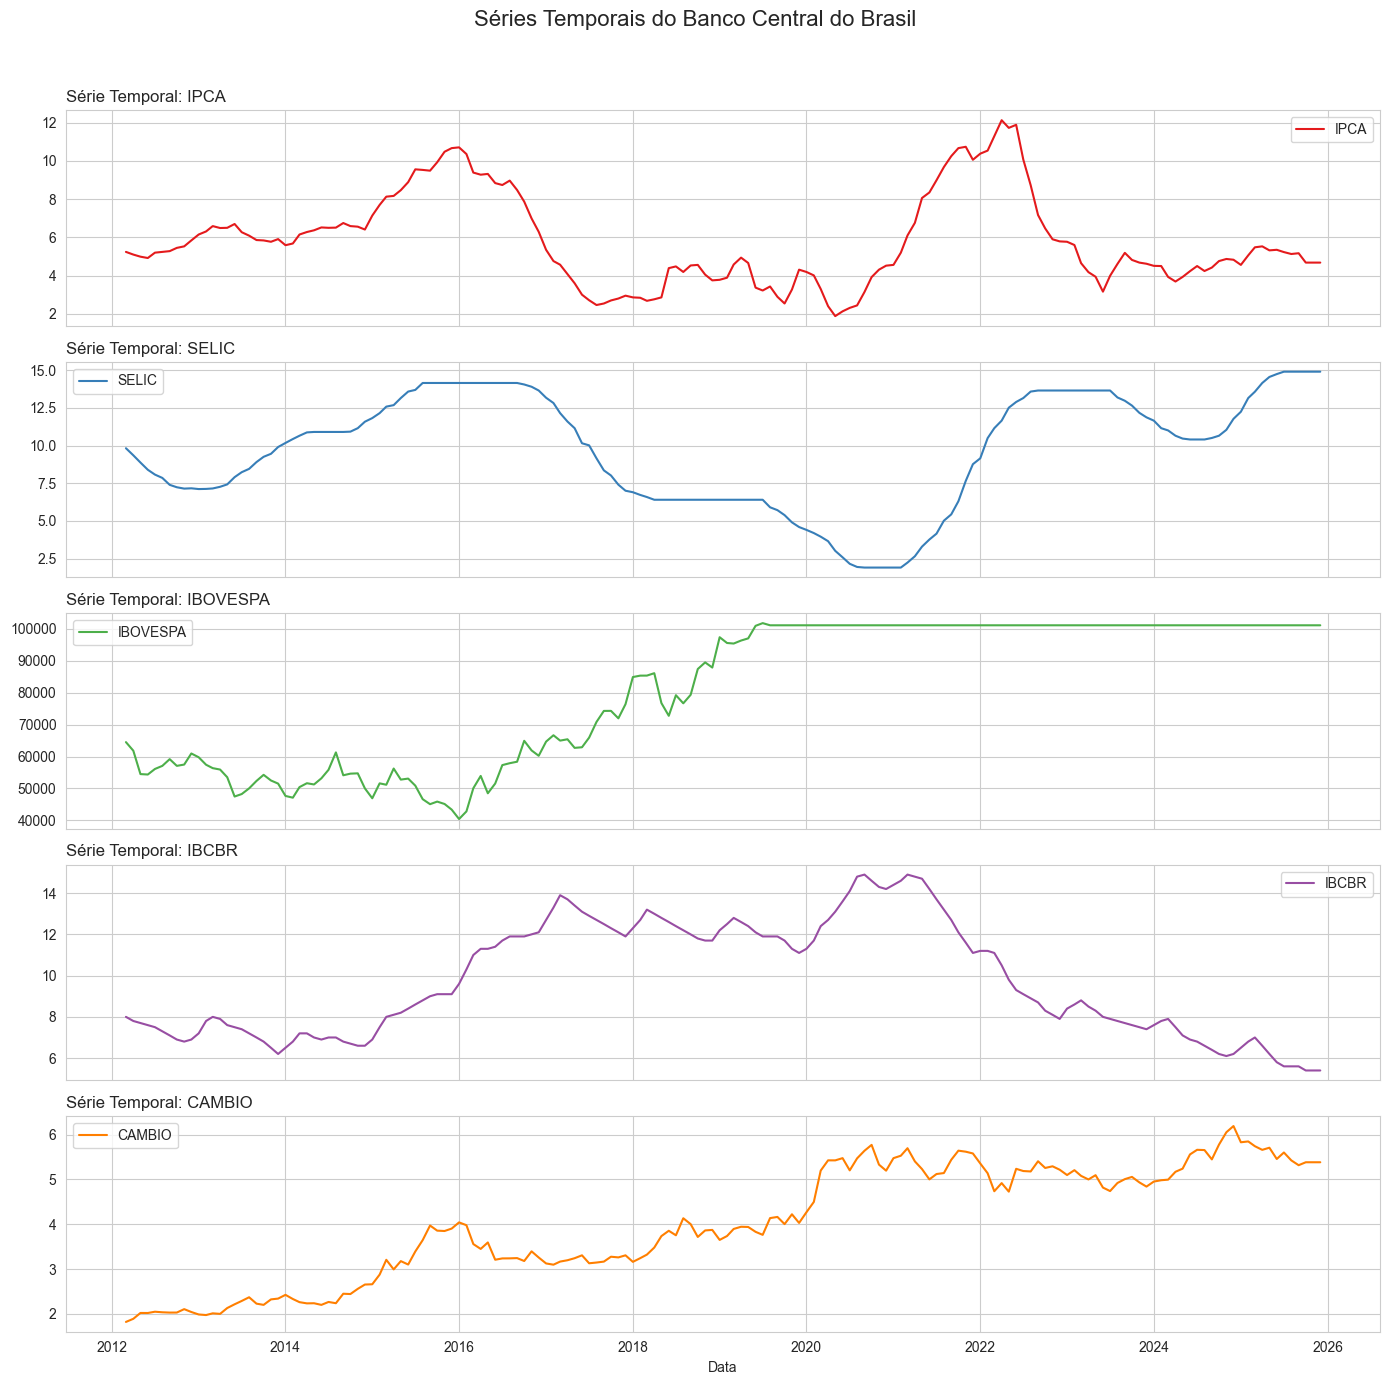

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR
from statsmodels.sandbox.regression.gmm import GMM

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

df = pd.read_excel(
    "series_temporais_bcb.xlsx",
    index_col='Date',
    parse_dates=True
)

df.columns = ['IPCA', 'SELIC', 'IBOVESPA', 'IBCBR', 'CAMBIO']

print("Primeiras linhas do DataFrame:")
print(df.head())
print("\nInformações sobre o DataFrame:")
df.info()

fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(14, 15), sharex=True)
plt.suptitle('Séries Temporais do Banco Central do Brasil', fontsize=16, y=0.92)

for i, column in enumerate(df.columns):
    axes[i].plot(df.index, df[column], label=column, color=sns.color_palette("Set1")[i])
    axes[i].set_title(f'Série Temporal: {column}', loc='left')
    axes[i].legend(loc='best')
    axes[i].grid(True)

plt.xlabel("Data")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [ ]:
def run_unit_root_tests(series, name):
    print(f"\n=== Testes para a série: {name} ===")

    adf_result = adfuller(series.dropna())
    print("\nTeste Aumentado de Dickey-Fuller (ADF):") ## também para verificar se uma série e estacionária
    adf_output = {
        "Estatística ADF": adf_result[0],
        "Valor p": adf_result[1],
        "Lags Usados": adf_result[2],
        "Nº de Observações": adf_result[3],
        "Resultado": "Rejeita H0 (Estacionária)" if adf_result[1] <= 0.05 else "Não Rejeita H0 (Não Estacionária)"
    }
    print(pd.Series(adf_output))
    print(f"Valores Críticos: {adf_result[4]}")

    kpss_result = kpss(series.dropna(), regression='ct')
    print("\nTeste KPSS (com Tendência):")  ## para verificar a estacionariedade da série
    kpss_output = {
        "Estatística KPSS": kpss_result[0],
        "Valor p": kpss_result[1],
        "Lags Usados": kpss_result[2],
        "Resultado": "Rejeita H0 (Não Estacionária)" if kpss_result[1] <= 0.05 else "Não Rejeita H0 (Estacionária)"
    }
    print(pd.Series(kpss_output))
    print(f"Valores Críticos: {kpss_result[3]}")

## Dickey-Fuller - testa a não estacionariedade
## KSS - testa a hipótese nula de esatcionariedade

for col in df.columns:
    run_unit_root_tests(df[col], col)


=== Testes para a série: IPCA ===

Teste Aumentado de Dickey-Fuller (ADF):
Estatística ADF                              -2.574593
Valor p                                       0.098363
Lags Usados                                         13
Nº de Observações                                  152
Resultado            Não Rejeita H0 (Não Estacionária)
dtype: object
Valores Críticos: {'1%': np.float64(-3.474120870218417), '5%': np.float64(-2.880749791423677), '10%': np.float64(-2.5770126333102494)}

Teste KPSS (com Tendência):
Estatística KPSS                         0.094058
Valor p                                       0.1
Lags Usados                                     8
Resultado           Não Rejeita H0 (Estacionária)
dtype: object
Valores Críticos: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

=== Testes para a série: SELIC ===

Teste Aumentado de Dickey-Fuller (ADF):
Estatística ADF                              -1.605959
Valor p                                         0.4

C:\Users\Ryan\AppData\Local\Temp\ipykernel_11440\3916618392.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_11440\3916618392.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_11440\3916618392.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_11440\3916618392.py:16: InterpolationWarning: The test statistic is outside of the range o

In [7]:
print("\n" + "="*50)
print("3. Estimação da Equação por Mínimos Quadrados Ordinários (MQO)")
print("="*50)

Y = df['IBOVESPA']

X = df[['IPCA', 'SELIC', 'IBCBR', 'CAMBIO']]
X = sm.add_constant(X)

ols_model = sm.OLS(Y, X).fit()

print(ols_model.summary())


3. Estimação da Equação por Mínimos Quadrados Ordinários (MQO)
                            OLS Regression Results                            
Dep. Variable:               IBOVESPA   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     191.6
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           4.17e-60
Time:                        13:10:53   Log-Likelihood:                -1751.7
No. Observations:                 166   AIC:                             3513.
Df Residuals:                     161   BIC:                             3529.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Obteve forte ajuste - 0.826 - As variáveis explicam bem a variação do IBOVESPA

O modelo é estatísticamente significativo

In [8]:
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM

class LinearGMM(GMM):
    def momcond(self, params):

        params = np.asarray(params)

        errors = self.endog - np.dot(self.exog, params)

        moment_conditions = self.instrument * errors[:, np.newaxis]

        return moment_conditions

print("\n" + "="*50)
print("Tentativa de Estimação por Método dos Momentos Generalizados (GMM)")
print("==================================================")


try:
    start_params_np = np.asarray(ols_model.params)

    gmm_model_custom = LinearGMM(
        endog=Y,
        exog=X,
        instrument=instruments
    )

    gmm_results_custom = gmm_model_custom.fit(
        start_params=start_params_np,
        weights_method='iid',
        optim_method='bfgs'
    )

    print(gmm_results_custom.summary())

except Exception as e:
    print(f"\nOcorreu um erro durante a estimação GMM: {e}")
    print("Por favor, verifique a implementação das condições de momento (momcond) e os dados.")


Tentativa de Estimação por Método dos Momentos Generalizados (GMM)

Ocorreu um erro durante a estimação GMM: name 'instruments' is not defined
Por favor, verifique a implementação das condições de momento (momcond) e os dados.



5. Estimação de um Modelo VAR
Dimensão do DataFrame após diferenciação: (165, 5)

Seleção do Lag Ótimo para o VAR (Critério AIC):
Lag Ótimo Selecionado (AIC): 4

Resumo da Estimação VAR (Apenas uma visão parcial):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Dec, 2025
Time:                     13:10:54
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    6.20206
Nobs:                     161.000    HQIC:                   5.00843
Log likelihood:          -1374.74    FPE:                    66.6809
AIC:                      4.19244    Det(Omega_mle):         36.1222
--------------------------------------------------------------------
Results for equation IPCA
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const       

c:\Users\Ryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Ryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


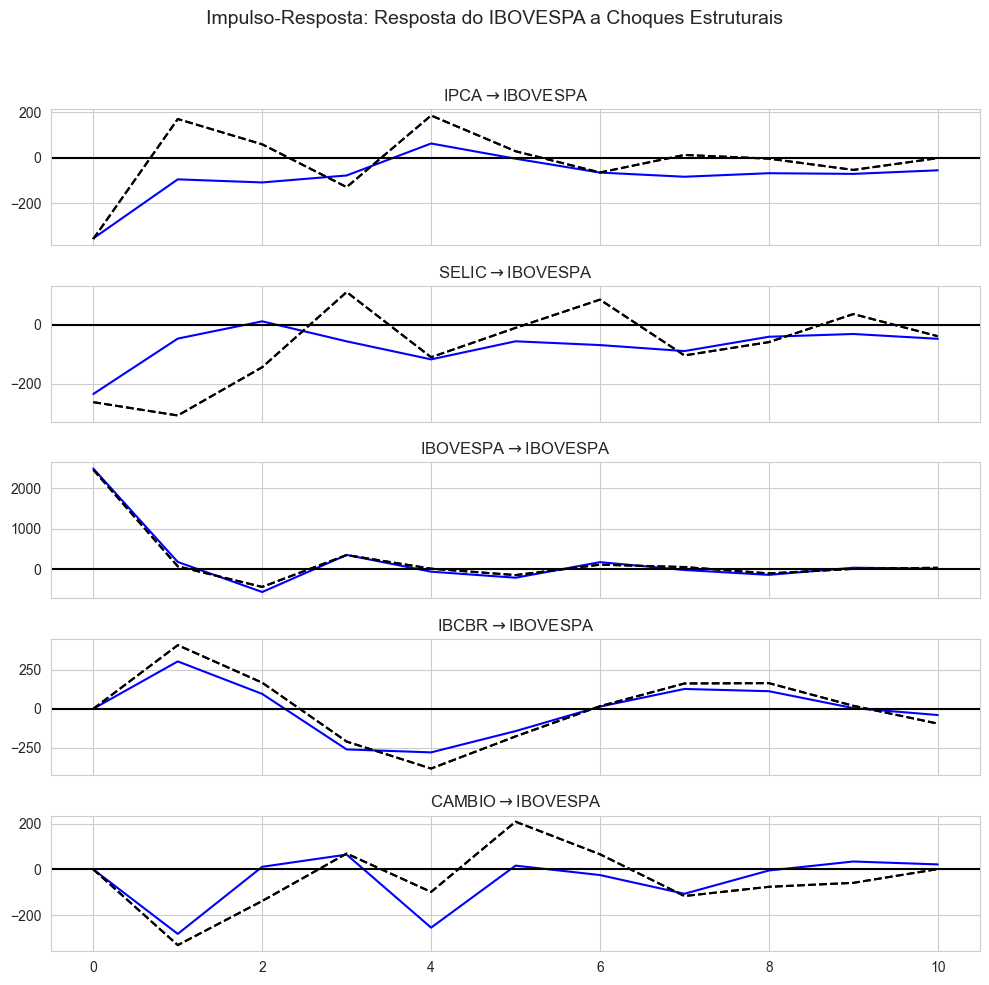


--------------------------------------------------
Tabela de Decomposição da Variância do Erro de Previsão
--------------------------------------------------

Inspecting FEVD object attributes:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'cov', 'decomp', 'irfobj', 'model', 'names', 'neqs', 'orth_irfs', 'periods', 'plot', 'summary']

FEVD object keys (if available):
FEVD object does not have a .keys() method.


AttributeError: 'FEVD' object has no attribute 'ibovespa'

In [ ]:
print("\n" + "="*50)
print("5. Estimação de um Modelo VAR")
print("="*50)


df_diff = df.diff().dropna()
print(f"Dimensão do DataFrame após diferenciação: {df_diff.shape}")


print("\nSeleção do Lag Ótimo para o VAR (Critério AIC):") ## AIC possui qualidade de ajuste e simplicidade
## Pois, ele penaliza os modelos que possuem parâmetros demais
var_lag_selection = sm.tsa.VAR(df_diff).select_order(maxlags=12) # Até 12 meses
optimal_lag = var_lag_selection.aic
print(f"Lag Ótimo Selecionado (AIC): {optimal_lag}") ## número ideal de defasagens
##No caso acima, utilizou-se de 12 meses retroativos para a previsão
var_model = sm.tsa.VAR(df_diff)
var_results = var_model.fit(optimal_lag)
print("\nResumo da Estimação VAR (Apenas uma visão parcial):")
print(var_results.summary())

print("\n" + "-"*50)
print("Gráficos de Impulso Resposta (IRF)") ## medem o 
##efeito de um choque (um aumento inesperado) em uma variável sobre 
# todas as outras variáveis do modelo ao longo do tempo
print("-" * 50)

irf = var_results.irf(periods=10) # 10 períodos à frente (meses)
irf_plot = irf.plot(orth=True, response='IBOVESPA',
                    plot_stderr=True, stderr_type='mc', seed=42)
plt.suptitle('Impulso-Resposta: Resposta do IBOVESPA a Choques Estruturais', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n" + "-"*50)
print("Tabela de Decomposição da Variância do Erro de Previsão")
print("-" * 50)

fevd = var_results.fevd(10) # 10 períodos à frente


print("\nInspecting FEVD object attributes:")  ## FEVD diz de onde vêm os erros do modelo de predição
## e responde quanto da Variância do erro na prev do IBOVESPA é explicada pelos choques em cada variável
print(dir(fevd))
print("\nFEVD object keys (if available):")
try:
    print(fevd.keys())
except AttributeError:
    print("FEVD object does not have a .keys() method.")


fevd_ibovespa = pd.DataFrame(fevd.ibovespa,
                             index=fevd.periods,
                             columns=df_diff.columns)
fevd_ibovespa.index.name = "Período"
fevd_ibovespa = fevd_ibovespa.apply(lambda x: x * 100) #porcentagem

print(fevd_ibovespa.to_markdown(floatfmt=".2f"))

fevd_ibovespa.plot.area(figsize=(10, 6), title='Decomposição da Variância do IBOVESPA (%)')
plt.ylabel("Porcentagem da Variância Explicada")
plt.xlabel("Período (Meses)")
plt.legend(title='Variável')
plt.show()

Assim, o modelo estimou como cada variável reage às suas variações passadas;


Linha azul = resposta estimada do modelo

Linha preta tracejada = intervalos de confiança (incerteza da estimativa)

Eixo horizontal = período após o choque (0 a 10)

Eixo vertical = magnitude da resposta (positivo = alta; negativo = queda)
